Mount the google drive if needed:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Oct  9 07:51:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


##**Install YOLOv8 and Other neccessary Dependencies**

In [18]:
# Pip install method (recommended)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.7/78.2 GB disk)


In [19]:
from ultralytics import YOLO

from IPython.display import display, Image

In [20]:
import os
import numpy as np
import shutil
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from PIL import Image
import os
import io
import glob
from IPython.display import Image, display


In [21]:
!pip install roboflow
!pip install ttach

# **Define Functions:**

**Function for removing roboflow IDs from the images in dataset:**

In [22]:
def rename_image_files(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    for file in files:
        if "." in file:
            # Split the filename using ".rf." as the separator
            name_parts = file.split(".rf.")
            if len(name_parts) == 2:
                # Extract the actual name and add '.jpg' to the end
                new_name = name_parts[0] + ".jpg"
                # Create the new absolute path for the file
                old_path = os.path.join(folder_path, file)
                new_path = os.path.join(folder_path, new_name)
                # Rename the file
                os.rename(old_path, new_path)
                print(f"Renamed: {file} -> {new_name}")

**Function for removing roboflow IDs from the labels in dataset:**

In [23]:
def rename_label_files(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    for file in files:
        if "." in file:
            # Split the filename using ".rf." as the separator
            name_parts = file.split(".rf.")
            if len(name_parts) == 2:
                # Extract the actual name and add '.jpg' to the end
                new_name = name_parts[0] + ".txt"
                # Create the new absolute path for the file
                old_path = os.path.join(folder_path, file)
                new_path = os.path.join(folder_path, new_name)
                # Rename the file
                os.rename(old_path, new_path)
                print(f"Renamed: {file} -> {new_name}")

**Define a function to classify images as Bleeding And Non-Bleeding :**

In [24]:
def classify_and_store_results(model, test_directory):
    # Create an ImageDataGenerator for loading and preprocessing test images
    test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

    # Load and preprocess test images from the test directory
    test_generator = test_datagen.flow_from_directory(
        test_directory,
        target_size=(224, 224),  # Adjust the target size to match your model's input size
        batch_size=1,
        shuffle=False,
        class_mode=None
    )

    # Make predictions on the test images
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

    # Get the image names from the generator
    image_names = [os.path.basename(image_path) for image_path in test_generator.filenames]
    # Get the predicted class labels based on the highest probability
    predicted_labels = ["Non-Bleeding" if prediction[1] > prediction[0] else "Bleeding" for prediction in predictions]

    # Create folders for Bleeding and Non-Bleeding images
    bleeding_folder = os.path.join(f"{HOME}/classified", "Bleeding_set")
    non_bleeding_folder = os.path.join(f"{HOME}/classified", "Non-Bleeding_set")

    %rm -r {HOME}/classified/*
    # Create the folders if they don't exist
    os.makedirs(bleeding_folder, exist_ok=True)
    os.makedirs(non_bleeding_folder, exist_ok=True)

    for image_name, predicted_label in zip(image_names, predicted_labels):
        source_path = os.path.join(test_directory,"images", image_name)
        if predicted_label == "Bleeding":
            destination_path = os.path.join(bleeding_folder, image_name)
        else:
            destination_path = os.path.join(non_bleeding_folder, image_name)

        print(f"Cloning: {source_path} -> {destination_path}")

        # Verify file existence before moving
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
        else:
            print(f"Source file not found: {source_path}")
            # If the source file is not found, move it to the "Non-Bleeding" folder
            shutil.copy(destination_path, source_path)

    return bleeding_folder


**Define a function to merge the Bleeding and Non-Bleeding Predicttion Label into one prediction folder.**

In [25]:
def process_image_labels(classified_folder, label_folder, predicted_label_folder):
    # Create the predicted label folder if it doesn't exist
    os.makedirs(predicted_label_folder, exist_ok=True)

    # Step 1- Copy labels of "bleeding" images
    %cp -r {label_folder}/* {predicted_label_folder}

    print("Bleeding labels Merged")

    # Step 2- Create labels for "non_bleeding" images
    non_bleeding_folder = os.path.join(classified_folder, "Non-Bleeding_set")
    for root, _, files in os.walk(non_bleeding_folder):
      for file in files:
        if file.endswith(".jpg") or file.endswith(".png"): # Adjusting file extensions as needed
          label_file = file.split(".")[0] + ".txt"
          label_path = os.path.join(label_folder, label_file)
          with open(label_path, "w") as label_file:
            label_file.write("1 0.5 0.5 1 1")  #storing the class as 1 and the whole image as a yolo bbox , since it has been classified as non-bleeding frame.

    print("Non_Bleeding labels Merged")

**function to claculate iou:**

In [26]:
def calculate_iou(box1, box2):
    x1_pred, y1_pred, w_pred, h_pred = box1
    x1_gt, y1_gt, w_gt, h_gt = box2

    # Calculate the coordinates of the top-left and bottom-right corners of the predicted bounding box
    x1_pred, y1_pred = x1_pred - w_pred / 2, y1_pred - h_pred / 2
    x2_pred, y2_pred = x1_pred + w_pred, y1_pred + h_pred

    # Calculate the coordinates of the top-left and bottom-right corners of the ground truth bounding box
    x1_gt, y1_gt = x1_gt - w_gt / 2, y1_gt - h_gt / 2
    x2_gt, y2_gt = x1_gt + w_gt, y1_gt + h_gt

    # Calculate the coordinates of the intersection rectangle
    x1_intersection = max(x1_pred, x1_gt)
    y1_intersection = max(y1_pred, y1_gt)
    x2_intersection = min(x2_pred, x2_gt)
    y2_intersection = min(y2_pred, y2_gt)

    # Calculate the area of the intersection rectangle
    intersection_area = max(0, x2_intersection - x1_intersection) * max(0, y2_intersection - y1_intersection)

    # Calculate the area of the predicted and ground truth bounding boxes
    pred_area = w_pred * h_pred
    gt_area = w_gt * h_gt

    # Calculate the Union area
    union_area = pred_area + gt_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

**Function to calculate overall iou of the two classes:**

In [27]:
def calculate_overall_iou_class(threshold, pred_folder, gt_folder):
    # Initialize class-wise variables
    iou_class_0, iou_class_1 = 0, 0
    n_class_0, n_class_1 = 0, 0

    # Loop through the files in the predicted label folder
    for file_name in os.listdir(pred_folder):
        # Read the predicted and ground truth labels
        pred_boxes, pred_classes = read_label_file(os.path.join(pred_folder, file_name))
        gt_boxes, gt_classes = read_label_file(os.path.join(gt_folder, file_name))

        # Initialize per-file variables
        iou_file = [0, 0]
        tp_file = [0, 0]
        fp_file = [0, 0]
        fn_file = [0, 0]

        # Loop through the predicted boxes and classes
        for i in range(len(pred_boxes)):
            pred_class = pred_classes[i]
            # Find the best matching ground truth box and class
            best_iou, best_index = 0, -1
            for j in range(len(gt_boxes)):
                iou = calculate_iou(pred_boxes[i], gt_boxes[j])
                if iou > best_iou and pred_class == gt_classes[j]:
                    best_iou = iou
                    best_index = j

            if best_iou >= threshold:
                tp_file[pred_class] += 1
                gt_boxes.pop(best_index)
                gt_classes.pop(best_index)
            else:
                fp_file[pred_class] += 1

        fn_file[0] = gt_classes.count(0)
        fn_file[1] = gt_classes.count(1)

        for class_id in [0, 1]:
            iou_file[class_id] = tp_file[class_id] / (tp_file[class_id] + fp_file[class_id] + fn_file[class_id]) if (tp_file[class_id] + fp_file[class_id] + fn_file[class_id]) > 0 else None
            if iou_file[class_id] is not None:
                if class_id == 0:
                    iou_class_0 += iou_file[class_id]
                    n_class_0 += 1
                elif class_id == 1:
                    iou_class_1 += iou_file[class_id]
                    n_class_1 += 1

    # Calculate the overall IoU for each class
    iou_class_0 = iou_class_0 / n_class_0 if n_class_0 > 0 else None
    iou_class_1 = iou_class_1 / n_class_1 if n_class_1 > 0 else None

    # Return the overall IoU for each class as a tuple
    return iou_class_0, iou_class_1


**Define a function to read the label files and return a list of boxes and classes :**

In [28]:
def read_label_file(file_path):
    boxes = []
    classes = []
    with open(file_path, "r") as f:
        for line in f:
            # Split the line by spaces and convert to floats
            line = [float(x) for x in line.split()]
            # The first element is the class, the rest are the box coordinates
            classes.append(int(line[0]))
            boxes.append(line[1:])
    return boxes, classes

**Define a function to calculate the average precision of a class for a given threshold:**

In [29]:
def calculate_ap_class(threshold, pred_folder, gt_folder, class_id):
    # Initialize some variables
    ap = 0  # Average precision
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives

    # Loop through the files in the predicted label folder
    for file_name in os.listdir(pred_folder):
        # Read the predicted boxes and classes
        pred_boxes, pred_classes = read_label_file(os.path.join(pred_folder, file_name))
        # Read the ground truth boxes and classes
        gt_boxes, gt_classes = read_label_file(os.path.join(gt_folder, file_name))
        # Loop through the predicted boxes and classes
        for i in range(len(pred_boxes)):
            # Only consider the predictions that belong to the given class
            if pred_classes[i] == class_id:
                # Find the best matching ground truth box and class
                best_iou = 0  # Best intersection over union
                best_index = -1  # Best index
                for j in range(len(gt_boxes)):
                    # Calculate the intersection over union between the predicted and ground truth box
                    iou = calculate_iou(pred_boxes[i], gt_boxes[j])
                    # Update the best iou and index if the iou is higher than the current best and the classes match
                    if iou > best_iou and pred_classes[i] == gt_classes[j]:
                        best_iou = iou
                        best_index = j
                # If the best iou is above the threshold, it is a true positive
                if best_iou >= threshold:
                    tp += 1
                    # Remove the matched ground truth box and class from the list to avoid double counting
                    gt_boxes.pop(best_index)
                    gt_classes.pop(best_index)
                # Otherwise, it is a false positive
                else:
                    fp += 1
        # The remaining ground truth boxes and classes that belong to the given class are false negatives
        fn += gt_classes.count(class_id)

    # Calculate the precision and recall
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    # Return the average precision as the product of precision and recall
    return precision * recall

**Function to generate Eigen-CAM for an image**

In [30]:
# Function to generate Eigen-CAM for an image
def generate_eigen_cam_for_image(model, image_path, target_layers):
    # Load and preprocess the image
    plt.rcParams["figure.figsize"] = [3.0, 3.0]
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    rgb_img = img.copy()
    img = np.float32(img) / 255

    # Create Eigen-CAM object
    cam = EigenCAM(model, target_layers, task='od')

    # Generate Eigen-CAM
    grayscale_cam = cam(rgb_img)[0, :, :]

    # Overlay Eigen-CAM on the original image
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    return cam_image


**Function to generate Eigen-CAM for a folder of images**

In [31]:
# Function to generate Eigen-CAM for a folder of images
def generate_eigen_cam_for_folder(model, input_folder, output_folder, target_layers):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of image file paths in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(input_folder, image_file)

        # Generate Eigen-CAM for the image
        cam_image = generate_eigen_cam_for_image(model, image_path, target_layers)

        # Save the CAM image to the output folder with the same name
        output_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_path, cam_image)

## CLI Basics

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://docs.ultralytics.com/usage/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

# **Downoad The Dataset**

In [32]:
%cd {HOME}

/content


Downloading the WCE_BLEED_GEN Dataset from Roboflow which I uploaded fro easy access , consistent data format (i.e., .jpg) and create the correctly formatted dataset to use will YoloV8.
The dataset has been split to 80% train data and 20% validation data.
Here is the folder structure :
 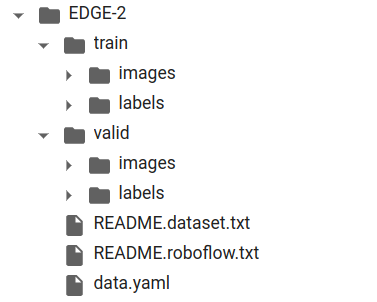

In [33]:
from roboflow import Roboflow
rf = Roboflow(api_key="nf3h3lrrfqZKQnKkkTFX")
project = rf.workspace("edge-naada").project("edge-qequy")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.20, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to EDGE-2 in yolov8:: 100%|██████████| 4933/4933 [00:00<00:00, 6576.62it/s]


Remove the roboflow IDs from the images of train and validation dataset:

In [34]:
# Provide the folder path here
folder_path = "/content/EDGE-2/train/images"
rename_image_files(folder_path)
folder_path = "/content/EDGE-2/valid/images"
rename_image_files(folder_path)

Renamed: img-494-_png.rf.71943f62a3cb53153f10cd3ea74d0c95.jpg -> img-494-_png.jpg
Renamed: img-971-_png.rf.51c1753fccf2b57cc7d1cbf189ad45c3.jpg -> img-971-_png.jpg
Renamed: img-959-_png.rf.b349f7ffd16e34ffc75d2da8fabbcf85.jpg -> img-959-_png.jpg
Renamed: img-659-nb_png.rf.5b054a4d6cd100b017fdc14dca083f44.jpg -> img-659-nb_png.jpg
Renamed: img-978-_png.rf.915285fe099ae4c43faa81c11271cdf1.jpg -> img-978-_png.jpg
Renamed: img-1239-_png.rf.a6b13ca6bcc577e16bbb34be6d7e8f75.jpg -> img-1239-_png.jpg
Renamed: img-734-nb_png.rf.ec8de54011f0cab5b37d9b659c26ff6f.jpg -> img-734-nb_png.jpg
Renamed: img-1289-nb_png.rf.84428a61aeb69f5bac5d5c6066da7e0c.jpg -> img-1289-nb_png.jpg
Renamed: img-52-_png.rf.7ad00c3afa5d3b5a067904c5fdadcd96.jpg -> img-52-_png.jpg
Renamed: img-192-_png.rf.7f820df0ee9f73a84646f730dc73ebbe.jpg -> img-192-_png.jpg
Renamed: img-1284-_png.rf.59b52765a87f66e2f9442481b774d350.jpg -> img-1284-_png.jpg
Renamed: img-966-_png.rf.df38162e34b1e39696e1d95b75ac21c6.jpg -> img-966-_png.jpg


Remove the roboflow IDs from the labels of train and validation dataset:

In [35]:
# Provide the folder path here
folder_path = "/content/EDGE-2/train/labels"
rename_label_files(folder_path)
folder_path = "/content/EDGE-2/valid/labels"
rename_label_files(folder_path)

Renamed: img-1178-_png.rf.6ba1ea97be155f4836a36116d608b61f.txt -> img-1178-_png.txt
Renamed: img-533-nb_png.rf.c5f1f901d54f5e74c521c93578aed07c.txt -> img-533-nb_png.txt
Renamed: img-884-nb_png.rf.9bdd89d599f5dd604b84ff2ae0eec502.txt -> img-884-nb_png.txt
Renamed: img-359-_png.rf.5656ea1732f53bf5988ca8af66f0d152.txt -> img-359-_png.txt
Renamed: img-1114-_png.rf.b0b00b64a0be9da00e7ac1a6518f43de.txt -> img-1114-_png.txt
Renamed: img-771-_png.rf.8275d315b93b503d60e0d71eb24fed1e.txt -> img-771-_png.txt
Renamed: img-1139-_png.rf.208c9b505c6a3f6c981649594302ccad.txt -> img-1139-_png.txt
Renamed: img-650-_png.rf.346070a1e102a7a241ff328b2fd10ee3.txt -> img-650-_png.txt
Renamed: img-920-nb_png.rf.3b0278cc889cff0b7d7c1479bb55b6f3.txt -> img-920-nb_png.txt
Renamed: img-829-nb_png.rf.1d37cc0b34664f1cc997bee829da730b.txt -> img-829-nb_png.txt
Renamed: img-749-_png.rf.15b5558b993f606dac14a02e7e5d7968.txt -> img-749-_png.txt
Renamed: img-1205-_png.rf.95ddbc3bf5e606140fc917b301fd8825.txt -> img-1205-_

# **Training**

Check the data.yaml file . It should look like this :
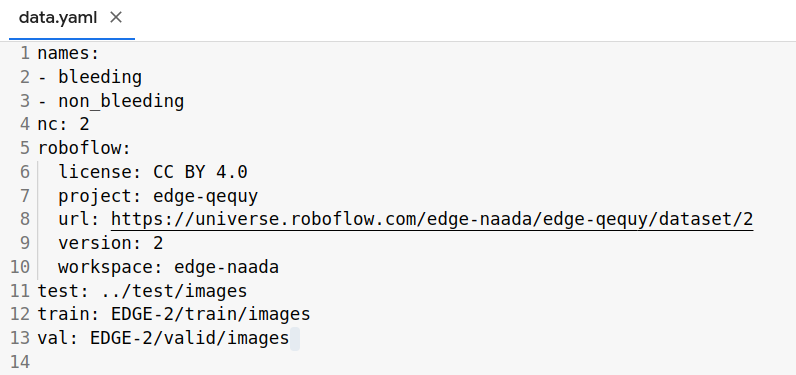

Change the paths if needed, according to the folder sructure.

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=200 imgsz=224 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 37.8MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/EDGE-B-1/data.yaml, epochs=200, patience=50, batch=16, imgsz=224, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False,

## **Visualize Results:**

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    train_batch0.jpg
events.out.tfevents.1694357326.d4ab6a986cf2.5954.0  train_batch1.jpg
results.csv					    train_batch2.jpg
results.png					    weights


/content


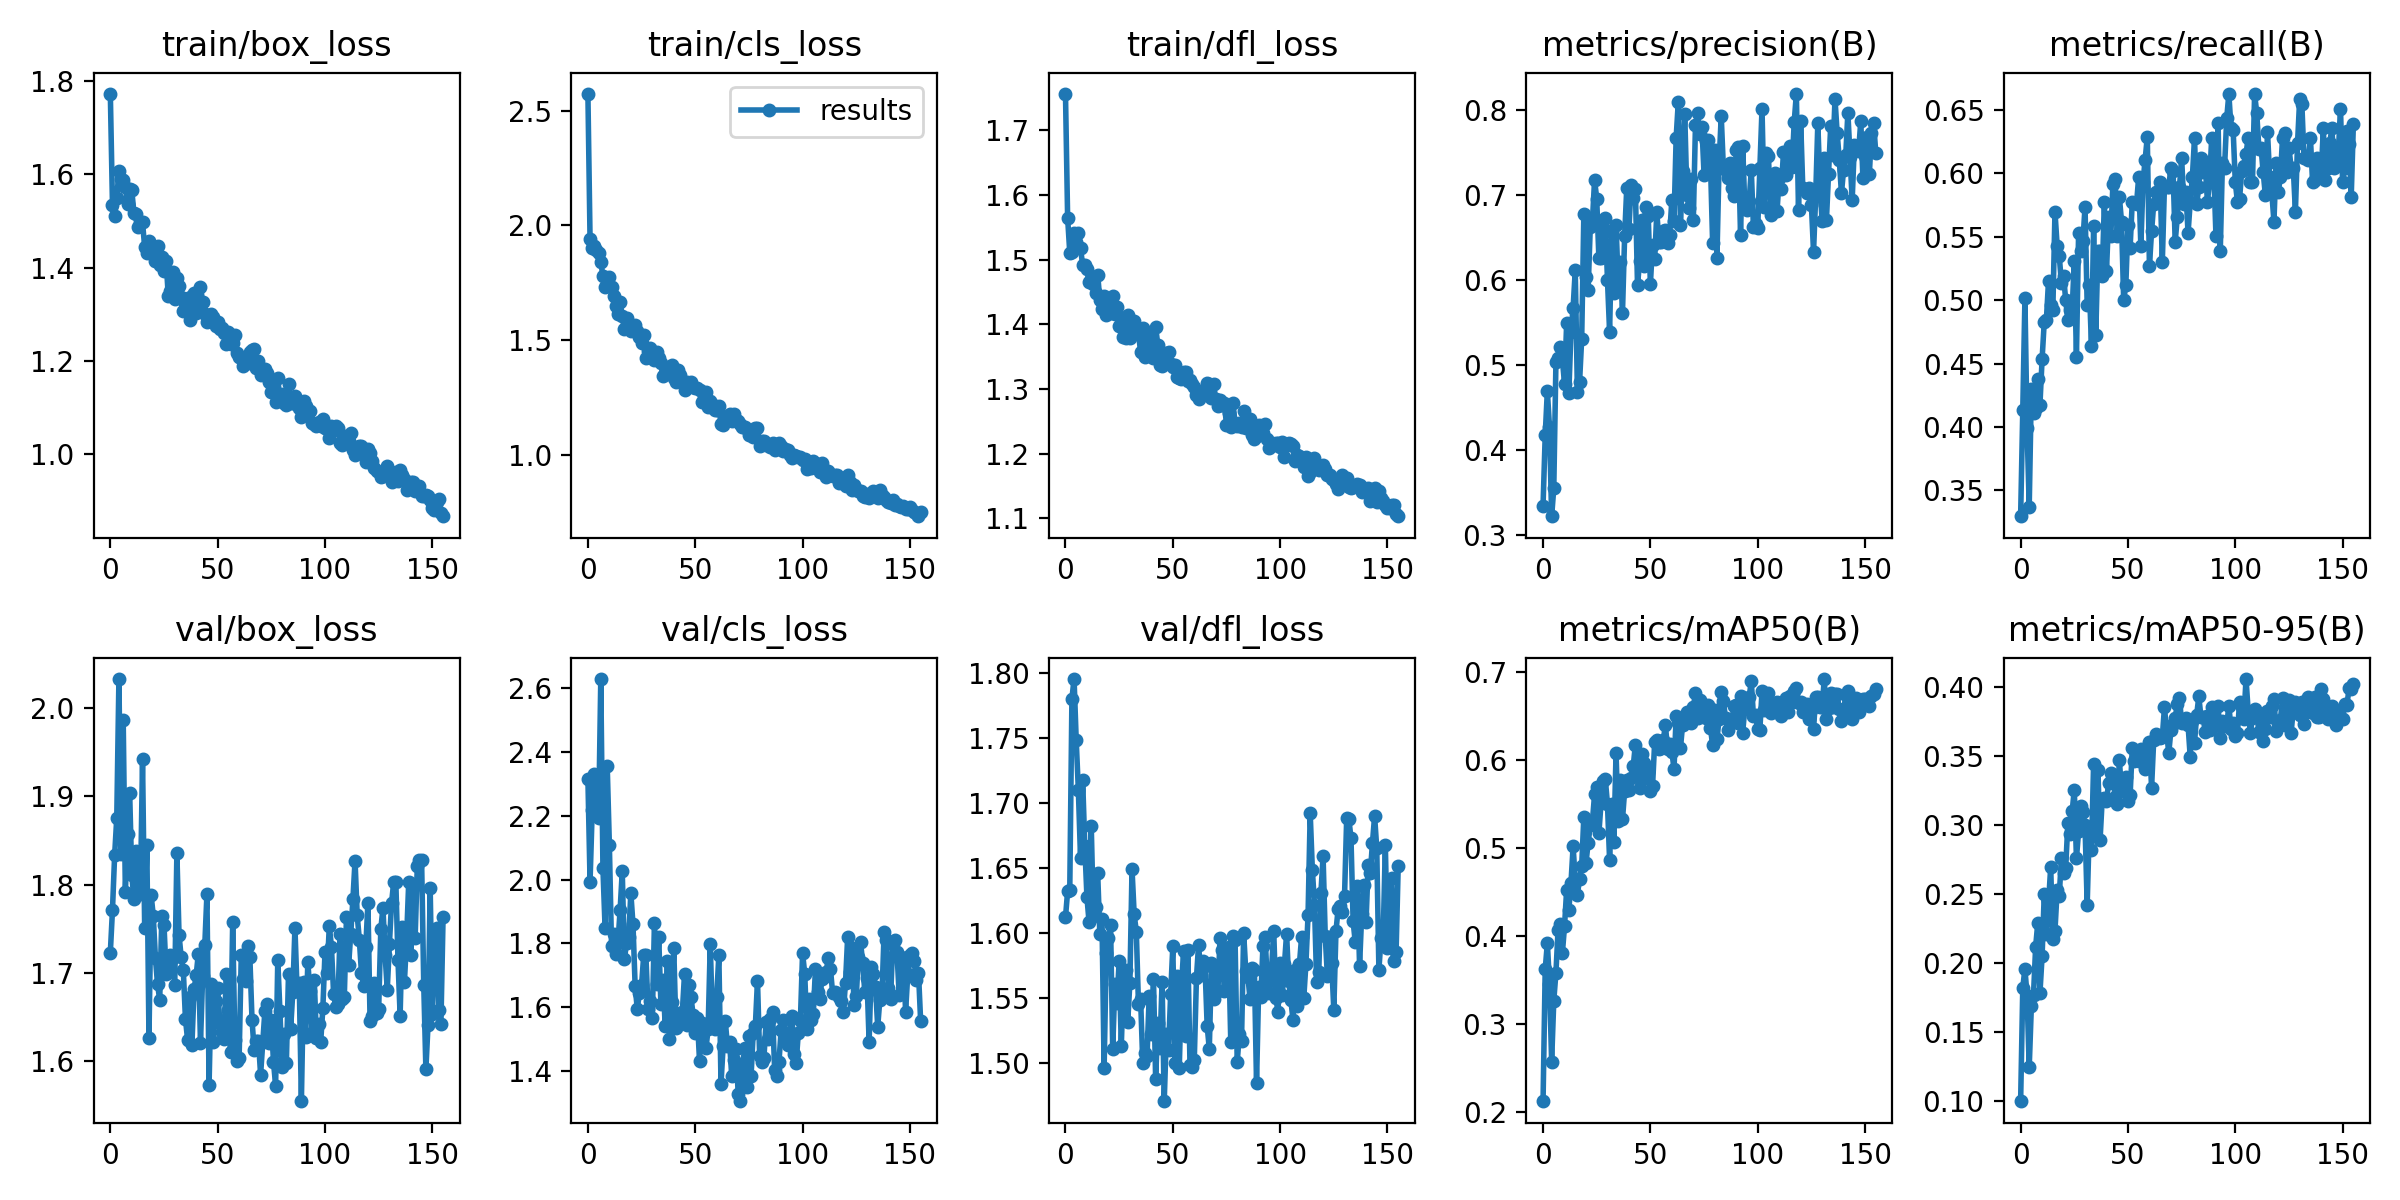

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

# **Validating the Custom Model**

Classify the data as Bleeding or Non-Bleeding. Then Predict on the Bleeding set.

In [40]:
# Load your trained classification model
model = tf.keras.models.load_model('/content/drive/MyDrive/WCEBleedGen/S3N/weights/model_cls.h5')  # Replace with your classification model file

# Specify the directory containing validation images
test_directory = '/content/EDGE-2/valid/'  # Replace with your test image directory

# Call the function to classify images and store results in Excel
path=classify_and_store_results(model, test_directory)

#detect with yolo model on the classified bleeding folder
%cd /content
%rm -r runs/detect/predict #delete preexisting unnecessary folder
!yolo task=detect mode=predict model=/content/drive/MyDrive/WCEBleedGen/S3N/weights/best.pt conf=0.20 source={path} save=True save_txt=True nms=True agnostic_nms=True



Found 494 images belonging to 2 classes.
494/494 [==============================] - 15s 9ms/step
rm: cannot remove '/content/classified/*': No such file or directory
Cloning: /content/EDGE-2/valid/images/img-1-_png.jpg -> /content/classified/Bleeding_set/img-1-_png.jpg
Cloning: /content/EDGE-2/valid/images/img-10-_png.jpg -> /content/classified/Bleeding_set/img-10-_png.jpg
Cloning: /content/EDGE-2/valid/images/img-1000-nb_png.jpg -> /content/classified/Non-Bleeding_set/img-1000-nb_png.jpg
Cloning: /content/EDGE-2/valid/images/img-1001-_png.jpg -> /content/classified/Bleeding_set/img-1001-_png.jpg
Cloning: /content/EDGE-2/valid/images/img-1004-_png.jpg -> /content/classified/Bleeding_set/img-1004-_png.jpg
Cloning: /content/EDGE-2/valid/images/img-1004-nb_png.jpg -> /content/classified/Non-Bleeding_set/img-1004-nb_png.jpg
Cloning: /content/EDGE-2/valid/images/img-1008-_png.jpg -> /content/classified/Bleeding_set/img-1008-_png.jpg
Cloning: /content/EDGE-2/valid/images/img-1009-_png.jpg ->

**merge all predicted labels, bleeding and non_bleeding into one label folder:**

In [41]:
classified_folder = f"{HOME}/classified"
label_folder = f"{HOME}/runs/detect/predict/labels"
predicted_label_folder = f"{HOME}/predicted/labels" #initialize your output predicted label folder
%rm -r {predicted_label_folder} #remove unnecessary pre-existing folder

process_image_labels(classified_folder, label_folder, predicted_label_folder)
process_image_labels(classified_folder, label_folder, predicted_label_folder)#running the function twice , since the labels didn't seem to get merged at first call.

Bleeding labels Merged
Non_Bleeding labels Merged
Bleeding labels Merged
Non_Bleeding labels Merged


**Calculate the AP50 AND AP75 for both classes and also calculate the mAP50 and mAP75 :**

In [42]:
predicted_folder = f'{HOME}/predicted/labels'  #the path to predicted label files
ground_truth_folder = f'{HOME}/EDGE-2/valid/labels'  #the path to ground truth label files

# Calculate and print AP values for class 0 at different IoU threshold
class_id_0 = 0
ap50_cls0 = calculate_ap_class(0.50, predicted_folder, ground_truth_folder, class_id_0)
ap75_cls0 = calculate_ap_class(0.75, predicted_folder, ground_truth_folder, class_id_0)

# Calculate and print AP values for class 1 at different IoU thresholds
class_id_1 = 1

ap50_cls1 = calculate_ap_class(0.50, predicted_folder, ground_truth_folder, class_id_1)
ap75_cls1 = calculate_ap_class(0.75, predicted_folder, ground_truth_folder, class_id_1)

# Print AP values for both classes and thresholds
print(f"Bleeding AP50 : {ap50_cls0:.4f}")
print(f"Bleeding AP75 : {ap75_cls0:.4f}")
print(f"Non Bleeding AP50 : {ap50_cls1:.4f}")
print(f"Non Bleeding AP75 : {ap75_cls1:.4f}")

# Calculate mAP for both classes at IoU threshold 0.50 and 0.75
mAP_50 = (ap50_cls0 + ap50_cls1) / 2
mAP_75 = (ap75_cls0 + ap75_cls1) / 2

# Print mAP values
print(f"mAP_50: {mAP_50:.4f}")
print(f"mAP_75: {mAP_75:.4f}")

Bleeding AP50 : 0.7464
Bleeding AP75 : 0.6021
Non Bleeding AP50 : 1.0000
Non Bleeding AP75 : 1.0000
mAP_50: 0.8732
mAP_75: 0.8010


**Calculate overall IoU of each class for 0.50 & 0.75 threshold** *(Run this cell twice if it shows iou as "None")* :

In [43]:
# Define the paths to the predicted and ground truth label folders
predicted_folder = f'{HOME}/predicted/labels'  # Replace with the path to predicted label files
ground_truth_folder = f'{HOME}/EDGE-2/valid/labels'  # Replace with the path to ground truth label files

# Define the IoU thresholds
thresholds = [0.50, 0.75]

# Initialize dictionaries to store the results
iou_results = {}

# Calculate IoU for each threshold
for threshold in thresholds:
    iou_class_0, iou_class_1 = calculate_overall_iou_class(threshold, predicted_folder, ground_truth_folder)
    iou_results[threshold] = (iou_class_0, iou_class_1)

# Print the results for each threshold
for threshold, (iou_class_0, iou_class_1) in iou_results.items():
    print(f"IoU Results for Threshold {threshold}:")
    print(f"Overall IoU for Class 0: {iou_class_0}")
    print(f"Overall IoU for Class 1: {iou_class_1}")
    print()


IoU Results for Threshold 0.5:
Overall IoU for Class 0: 0.8588652482269504
Overall IoU for Class 1: 1.0

IoU Results for Threshold 0.75:
Overall IoU for Class 0: 0.773758865248227
Overall IoU for Class 1: 1.0



# **GRAD_CAM Result. Interpretaility Plot.**

## **Clone the EIGEN-CAM Software :**

In [ ]:
%cd /content
!git clone https://github.com/rigvedrs/YOLO-V8-CAM.git

/content
Cloning into 'YOLO-V8-CAM'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 66 (delta 19), reused 42 (delta 6), pack-reused 0
Receiving objects: 100% (66/66), 16.87 MiB | 31.12 MiB/s, done.
Resolving deltas: 100% (19/19), done.


**Function to generate Eigen-CAM for an image**

In [ ]:
# Function to generate Eigen-CAM for an image
def generate_eigen_cam_for_image(model, image_path, target_layers):
    # Load and preprocess the image
    plt.rcParams["figure.figsize"] = [3.0, 3.0]
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    rgb_img = img.copy()
    img = np.float32(img) / 255

    # Create Eigen-CAM object
    cam = EigenCAM(model, target_layers, task='od')

    # Generate Eigen-CAM
    grayscale_cam = cam(rgb_img)[0, :, :]

    # Overlay Eigen-CAM on the original image
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    return cam_image


**Function to generate Eigen-CAM for a folder of images**

In [ ]:
# Function to generate Eigen-CAM for a folder of images
def generate_eigen_cam_for_folder(model, input_folder, output_folder, target_layers):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of image file paths in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(input_folder, image_file)

        # Generate Eigen-CAM for the image
        cam_image = generate_eigen_cam_for_image(model, image_path, target_layers)

        # Save the CAM image to the output folder with the same name
        output_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_path, cam_image)

## **Generate Eigen-CAM on a folder:**

In [ ]:
%cd /content/YOLO-V8-CAM
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

/content/YOLO-V8-CAM


In [ ]:
# Load your trained model
model = YOLO('/content/drive/MyDrive/WCEBLEEDGen/weights/runs/detect/train2/weights/best.pt')

# Specify the input and output folders
input_folder = os.path.join(f'{path}') # Replace with your input image folder
output_folder = f'{HOME}/eigen_cam_output/'  # Replace with your output image folder

%rm -r {output_folder} #remove unnecessary pre-existing folder
!mkdir {output_folder}
# Specify the target layers for Eigen-CAM
target_layers = [model.model.model[-2]]

# Generate Eigen-CAM for the folder of images and save them
generate_eigen_cam_for_folder(model, input_folder, output_folder, target_layers)
print("Eigen-CAM images saved in", output_folder)

rm: cannot remove '/content/eigen_cam_output/': No such file or directory


Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


Eigen-CAM images saved in /content/eigen_cam_output/


**Visualize a few of the Eigen-Cam Images from the output folder:**

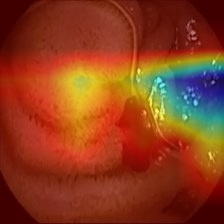


 img-1131-_png.jpg


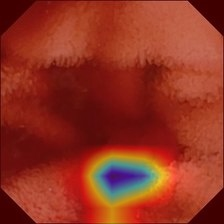


 img-460-_png.jpg


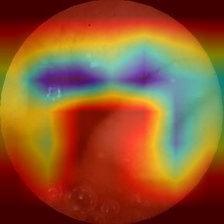


 img-201-_png.jpg


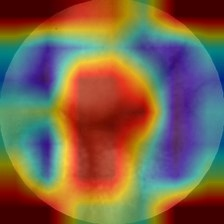


 img-180-_png.jpg


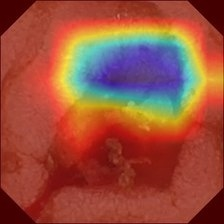


 img-642-_png.jpg


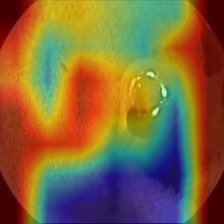


 img-1154-_png.jpg


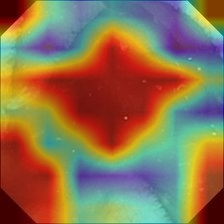


 img-254-_png.jpg


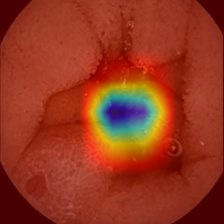


 img-953-_png.jpg


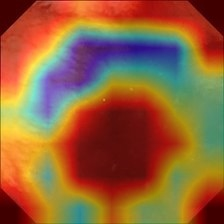


 img-372-_png.jpg


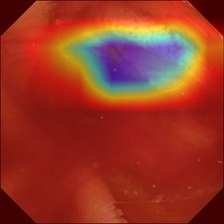


 img-265-_png.jpg


In [ ]:
for image_path in glob.glob(f'{output_folder}/*.jpg')[:10]:
      display(Image(filename=image_path, width=200))
      # Extract and print the image name
      image_name = os.path.basename(image_path)
      print(f"\n {image_name}")